In [1]:
# modules we will use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#set style for the graph plots
sns.set_style("dark")

# read in our data
bank_filepath = "bank_data.csv"
bank_data = pd.read_csv(bank_filepath)

#set seed for reproducibility
np.random.seed(0)

In [2]:
bank_data.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


In [3]:
#check for NaN under an entire DataFrame
bank_data.isnull().values.any()

False

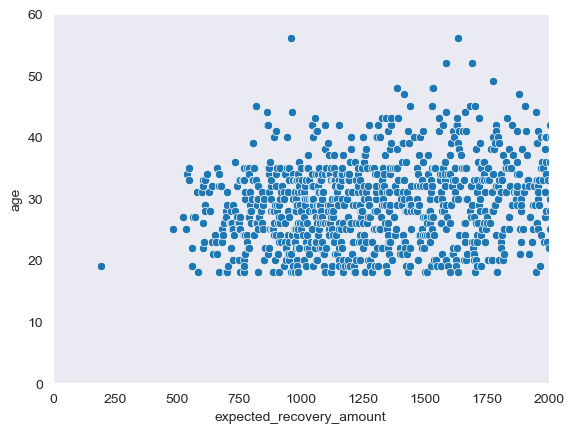

In [7]:
sns.scatterplot(x=bank_data['expected_recovery_amount'], y=bank_data['age'])
plt.ylim(0, 60)
plt.xlim(0,2000)
plt.show()

In [9]:
from scipy import stats

#average age of customers just above and below the threshold
era_900_1100 = bank_data[(bank_data['expected_recovery_amount'] >= 900) & 
               (bank_data['expected_recovery_amount'] < 1100)]
by_recovery_strategy = era_900_1100.groupby(['recovery_strategy'])
by_recovery_strategy['age'].describe().unstack()

#Kruskal-Wallis test
Level_0_age = era_900_1100.loc[bank_data['recovery_strategy']=="Level 0 Recovery"]['age']
Level_1_age = era_900_1100.loc[bank_data['recovery_strategy']=="Level 1 Recovery"]['age']
stats.kruskal(Level_0_age, Level_1_age)

KruskalResult(statistic=3.4572342749517513, pvalue=0.06297556896097407)

In [10]:
# Number of customers in each category
crosstab = pd.crosstab(bank_data.loc[(bank_data['expected_recovery_amount']<2000) &
                              (bank_data['expected_recovery_amount']>=0)]['recovery_strategy'],
                       bank_data['sex'])
print(crosstab)

# Chi-square test
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
print(p_val)

sex                Female  Male
recovery_strategy              
Level 0 Recovery      108   139
Level 1 Recovery      316   354
0.3941650543686612


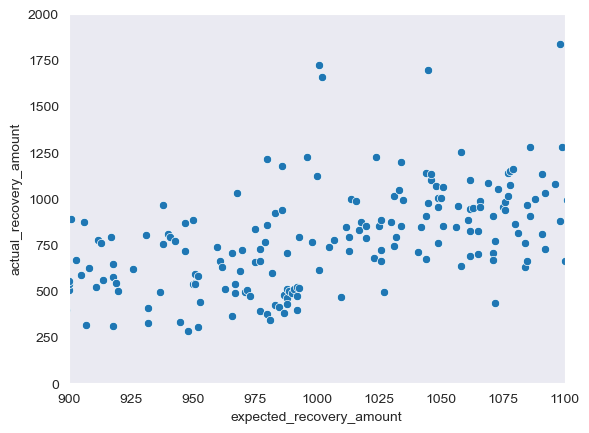

In [11]:
sns.scatterplot(x=bank_data['expected_recovery_amount'], y=bank_data['actual_recovery_amount'])
plt.xlim(900, 1100)
plt.ylim(0, 2000)
plt.show()

In [11]:
from scipy.stats import kruskal

# subset the data for the initial window (900 to 1100)
initial_window_data = bank_data[(bank_data['expected_recovery_amount'] >= 900) & (bank_data['expected_recovery_amount'] <= 1100)]
actual_recovery_initial = initial_window_data['actual_recovery_amount']

# subset the data for the adjusted window (950 to 1050)
adjusted_window_data = bank_data[(bank_data['expected_recovery_amount'] >= 950) & (bank_data['expected_recovery_amount'] <= 1050)]
actual_recovery_adjusted = adjusted_window_data['actual_recovery_amount']

# perform Kruskal-Wallis test
statistic, p_value = kruskal(actual_recovery_initial, actual_recovery_adjusted)

print(f"Kruskal-Wallis Test Statistic: {statistic}")
print(f"P-value: {p_value}")

Kruskal-Wallis Test Statistic: 0.823820206138487
P-value: 0.36406558976551284


In [14]:
# Regression Modeling without Threshold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

# Subset the data for Levels 0 and 1 (Expected Recovery Amounts between $0 to $2000)
data_subset = bank_data[(bank_data['expected_recovery_amount'] >= 0) & (bank_data['expected_recovery_amount'] <= 2000)]

# Define the input (independent) variable X and the output (dependent) variable Y
X = data_subset[['expected_recovery_amount']]
Y = data_subset['actual_recovery_amount']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# Create and fit the decision tree regression model
bank_model = DecisionTreeRegressor(random_state=1)
bank_model.fit(X_train, y_train)

# predictions on the test set
y_pred = bank_model.predict(X_test)

# Calculate mean absolute error to evaluate the model performance
error = mean_absolute_error(y_test, y_pred)
print(f"MAE: {error} ")

MAE: 391.35128575480076 


In [14]:
# regression modelling with threshold

bank_data['above_threshold'] = bank_data['expected_recovery_amount'] > 1000

# define the input (independent) variables X and the output (dependent) variable Y
X = bank_data[['expected_recovery_amount', 'above_threshold']]
Y = bank_data[['actual_recovery_amount']]

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

# create and fit the decision tree regression model
bank_model = DecisionTreeRegressor(random_state=1)
bank_model.fit(X_train, y_train)

# predictions on the test set
y_pred = bank_model.predict(X_test)

# calculate mean absolute error to evaluate model performance
error = mean_absolute_error(y_test, y_pred)
print(f"MAE: {error}")

MAE: 1324.6878321519453


In [17]:
#adjusting windows

# list of windows to test
windows = [(900, 1100), (950, 1050), (1000, 1200)]  # Adjust the ranges as needed

bank_data['above_threshold'] = bank_data['expected_recovery_amount'] > 1000

# a list to store mean absolute values for each window
mae_list = []

for window in windows:
    # Subset the data for the current window
    data_subset = bank_data[(bank_data['expected_recovery_amount'] >= window[0]) & (bank_data['expected_recovery_amount'] <= window[1])]

    # Define the input (independent) variables X and the output (dependent) variable Y
    X = data_subset[['expected_recovery_amount', 'above_threshold']]
    Y = data_subset['actual_recovery_amount']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

    # Create and fit the decision tree regression model
    bank_model = DecisionTreeRegressor(random_state=1)
    bank_model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = bank_model.predict(X_test)

    # Calculate R-squared to evaluate the model performance
    r_squared_with_threshold = mean_absolute_error(y_test, y_pred)
    
    # Append the R-squared value to the list
    mae_list.append(r_squared_with_threshold)

# Print the R-squared values for each window
for i, window in enumerate(windows):
    print(f"MAE for window {i + 1} ({window[0]} to {window[1]}): {mae_list[i]}")


MAE for window 1 (900 to 1100): 230.97223104594593
MAE for window 2 (950 to 1050): 286.91721485333335
MAE for window 3 (1000 to 1200): 326.2551417513889
